# Time series forecasting


## Data processing

In [51]:
# Import 

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
import os


In [38]:
start_date = "2010-01-01"
end_date = "2024-12-31"

# Dataset
df = yf.download("AAPL", start=start_date, end=end_date)

# Cette commande garde le niveau 0 ('Close', 'High'...) et jette le niveau 1 ('AAPL')
df.columns = df.columns.droplevel(1)

# Vérification : Affiche les nouvelles colonnes
print(df.columns)

# Features
df["return"] = df["Close"].pct_change()
df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))
df["log_volume"] = np.log(1 + df["Volume"])
df["high-low"] = df["High"] - df["Low"]

df = df.dropna()


/var/folders/vp/6wb8xsys5v93hnh1zt4zdj5w0000gn/T/ipykernel_28251/2813678749.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("AAPL", start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')


In [33]:
df.head()

Price,Close,High,Low,Open,Volume,return,log_return,log_volume,high-low
Date,,,,,,,,,
2010-01-05,6.429480,6.465769,6.395589,6.436078,601904800,0.001729,0.001727,20.215610,0.070179
2010-01-06,6.327211,6.454973,6.320613,6.429480,552160000,-0.015906,-0.016034,20.129348,0.134360
2010-01-07,6.315514,6.358101,6.269627,6.350604,477131200,-0.001849,-0.001850,19.983302,0.088474
2010-01-08,6.357501,6.358101,6.269928,6.307116,447610800,0.006648,0.006626,19.919435,0.088173
2010-01-11,6.301420,6.388094,6.251635,6.382096,462229600,-0.008821,-0.008860,19.951572,0.136459


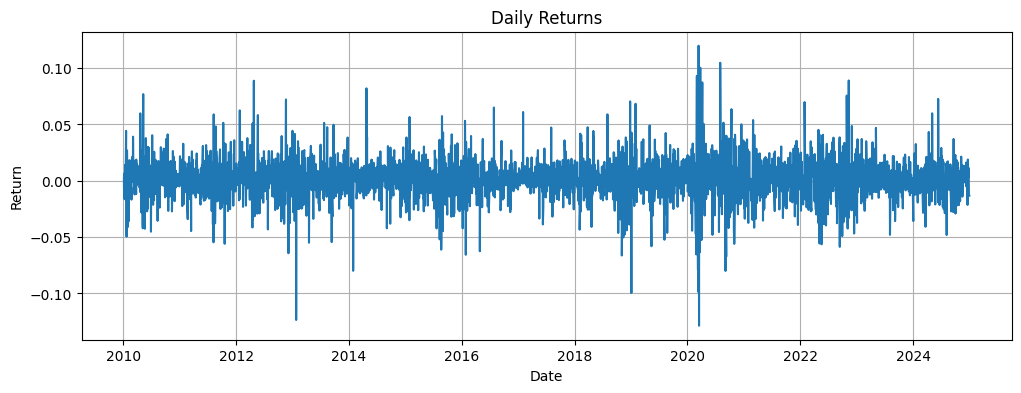

In [5]:
plt.figure(figsize=(12,4))
plt.plot(df["return"])
plt.title("Daily Returns")
plt.xlabel("Date")
plt.ylabel("Return")
plt.grid(True)
plt.show()


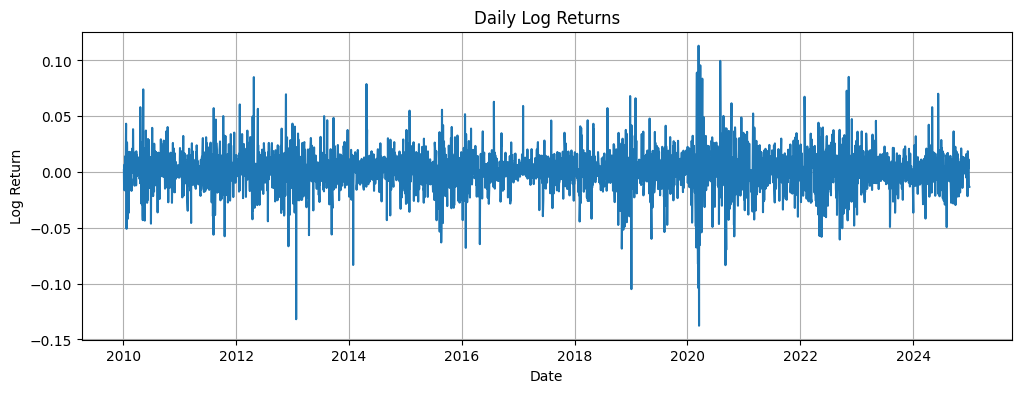

In [6]:
plt.figure(figsize=(12,4))
plt.plot(df["log_return"])
plt.title("Daily Log Returns")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.grid(True)
plt.show()

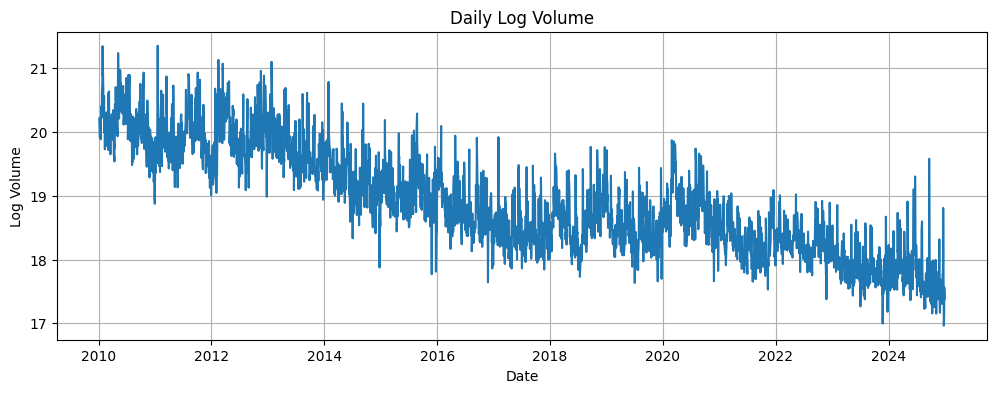

In [7]:
plt.figure(figsize=(12,4))
plt.plot(df["log_volume"])
plt.title("Daily Log Volume")
plt.xlabel("Date")
plt.ylabel("Log Volume")
plt.grid(True)
plt.show()

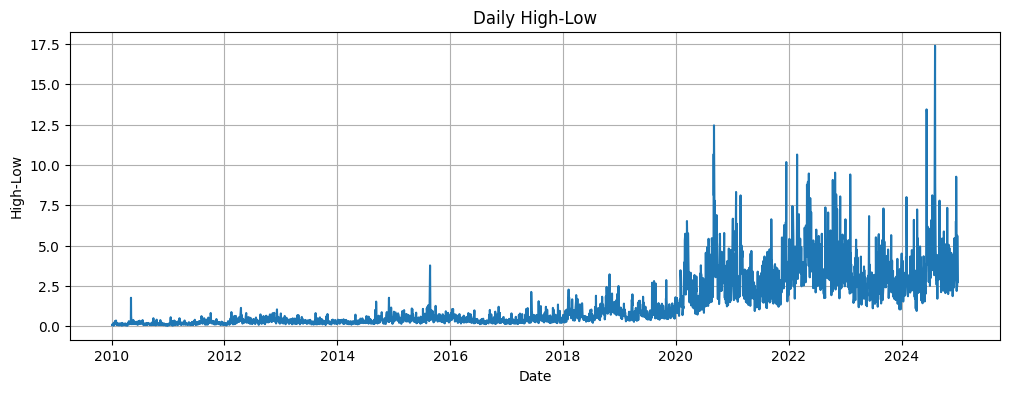

In [8]:
plt.figure(figsize=(12,4))
plt.plot(df["high-low"])
plt.title("Daily High-Low")
plt.xlabel("Date")
plt.ylabel("High-Low")
plt.grid(True)
plt.show()

## AR(1)

In [9]:
data = df["log_return"].values
n_test = 100  # Les 100 derniers points
train_data = [x for x in data[:-n_test]]
test_data = data[-n_test:]
pred_ar1 = []


for i in range(len(test_data)):
    model = AutoReg(train_data, lags=1).fit()
    
    pred_one_step = model.forecast(steps=1)[0]
    pred_ar1.append(pred_one_step)
    
    real_observation = test_data[i]
    train_data.append(real_observation)

mse = mean_squared_error(test_data, pred_ar1)
rmse = np.sqrt(mse)
print(f"RMSE Walk-Forward : {rmse:.5f}")



RMSE Walk-Forward : 0.01158


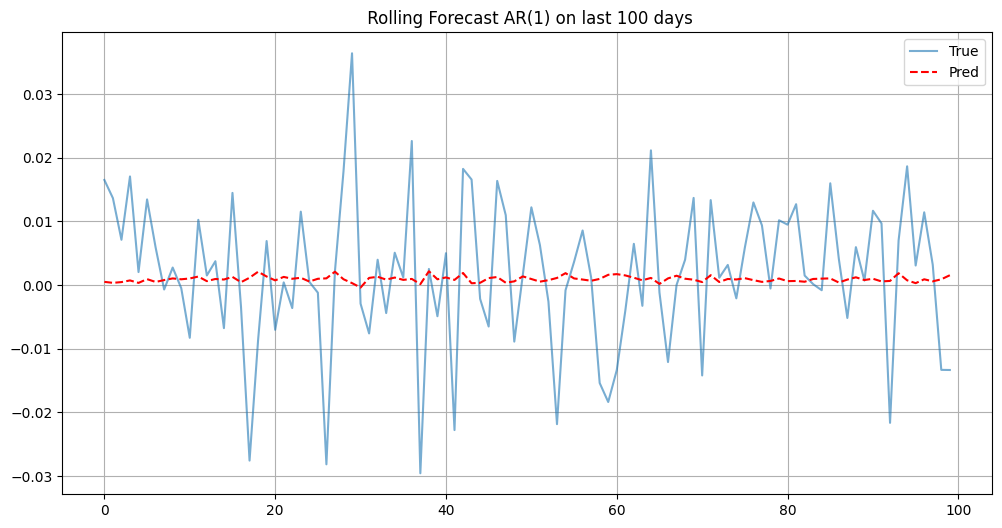

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 3771
Model:                     AutoReg(1)   Log Likelihood                9891.995
Method:               Conditional MLE   S.D. of innovations              0.018
Date:                Wed, 21 Jan 2026   AIC                         -19777.991
Time:                        09:05:51   BIC                         -19759.286
Sample:                             1   HQIC                        -19771.341
                                 3771                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.000      3.541      0.000       0.000       0.002
y.L1          -0.0388      0.016     -2.384      0.017      -0.071      -0.007
                                    Roots           

In [10]:
plt.figure(figsize=(12, 6))

plt.plot(range(n_test), test_data, label="True", alpha=0.6)
plt.plot(range(n_test), pred_ar1, label="Pred", color='red', linestyle='--')
plt.title(f" Rolling Forecast AR(1) on last {n_test} days")
plt.legend()
plt.grid(True)
plt.show()

print(model.summary())

In [11]:
y_true = np.array(test_data)
y_pred_ar1 = np.array(pred_ar1)

correct_direction = np.sign(y_true) == np.sign(y_pred_ar1)

hit_ratio = np.mean(correct_direction) * 100

print(f"Précision directionnelle (Hit Ratio) : {hit_ratio:.2f}%")

Précision directionnelle (Hit Ratio) : 62.00%


## ARIMA(1,0,1)

In [12]:
pred_arima = []

for t in range(len(test_data)):
    model = ARIMA(train_data, order=(1, 0, 1))
    model_fit = model.fit()

    output = model_fit.forecast()
    yhat = output[0]
    pred_arima.append(yhat)
    
    obs = test_data[t]
    train_data.append(obs)

mse = mean_squared_error(test_data, pred_arima)
rmse = np.sqrt(mse)
print(f'RMSE ARIMA: {rmse:.5f}')



/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: M

RMSE ARIMA: 0.01156


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


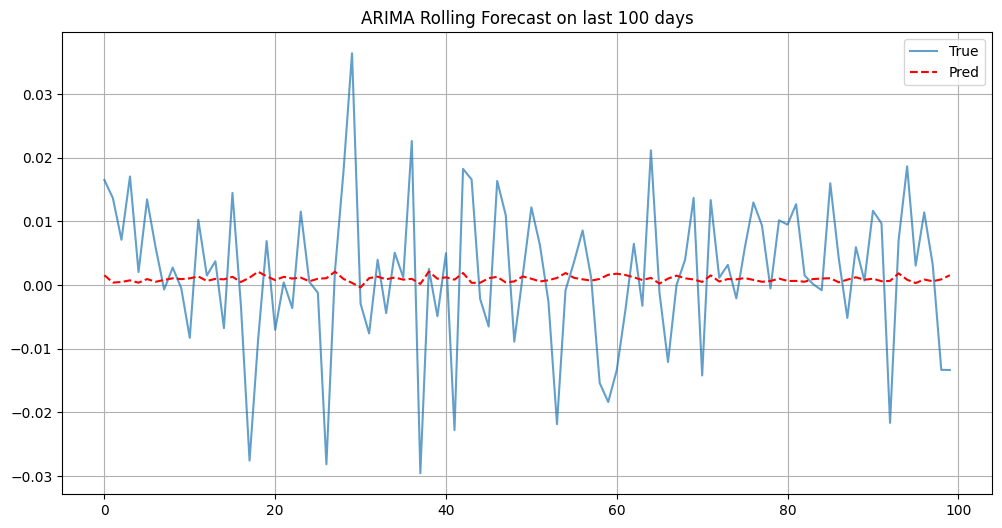

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3871
Model:                 ARIMA(1, 0, 1)   Log Likelihood               10186.071
Date:                Wed, 21 Jan 2026   AIC                         -20364.143
Time:                        09:06:15   BIC                         -20339.098
Sample:                             0   HQIC                        -20355.250
                               - 3871                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.000      3.559      0.000       0.000       0.002
ar.L1          0.0545      0.283      0.193      0.847      -0.499       0.608
ma.L1         -0.0928      0.284     -0.326      0.7

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(test_data, label='True', alpha=0.7)
plt.plot(pred_arima, color='red', linestyle='--', label='Pred')
plt.title('ARIMA Rolling Forecast on last {} days'.format(n_test))
plt.legend()
plt.grid(True)
plt.show()

print(model_fit.summary())

## LSTM

In [14]:
data = data.reshape(-1, 1)

# Normalisation
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Rolling window
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 60 
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Train/Test Split
split = len(X) - 100
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

model = Sequential()

# Couche LSTM
model.add(LSTM(units=50, return_sequences=False, input_shape=(SEQ_LENGTH, 1)))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compilation
model.compile(optimizer='adam', loss='mean_squared_error')

# Training
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Prediction
predictions_scaled = model.predict(X_test)

predictions = scaler.inverse_transform(predictions_scaled)
y_test_real = scaler.inverse_transform(y_test)

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0384 - val_loss: 0.0024
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0084 - val_loss: 0.0023
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0069 - val_loss: 0.0024
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0067 - val_loss: 0.0025
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0069 - val_loss: 0.0025
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0065 - val_loss: 0.0025
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0069 - val_loss: 0.0023
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0066 - val_loss: 0.0022
Epoch 9/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0062 - val_loss: 0.0022
Epoch 10/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0067 - val_loss: 0.0023
Epoch 11/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0062 - val_loss: 0.0022
Epoch 12/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0

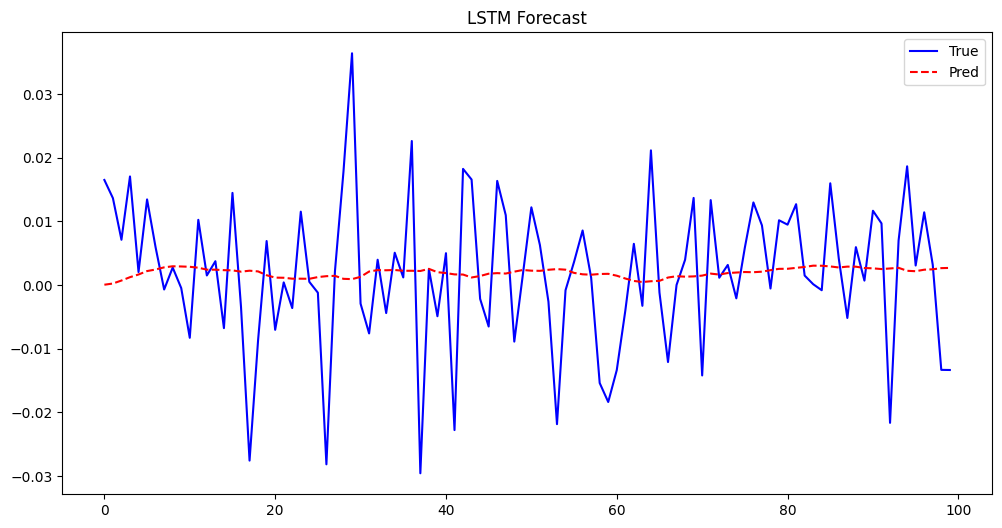

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_real, label='True', color='blue')
plt.plot(predictions, label='Pred', color='red', linestyle='--')
plt.title('LSTM Forecast')
plt.legend()
plt.show()

In [16]:
features = ['log_return', 'high-low', 'log_volume']
data = df[features].dropna().values  # Shape: (N, 3)

# Normalisation
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Rolling window
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length]) 
        y.append(data[i+seq_length, 0]) 
    return np.array(X), np.array(y)

SEQ_LENGTH = 60 
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Train/Test Split
split = len(X) - 100
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Couche LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(SEQ_LENGTH, 3)))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Training
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Prediction
predictions_scaled = model.predict(X_test)

dummy_pred = np.zeros((len(predictions_scaled), 3))
dummy_pred[:, 0] = predictions_scaled.flatten()
predictions = scaler.inverse_transform(dummy_pred)[:, 0]

dummy_y = np.zeros((len(y_test), 3))
dummy_y[:, 0] = y_test
y_test_real = scaler.inverse_transform(dummy_y)[:, 0]



Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0345 - val_loss: 0.0027
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0089 - val_loss: 0.0022
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0076 - val_loss: 0.0025
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0072 - val_loss: 0.0032
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0067 - val_loss: 0.0022
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0067 - val_loss: 0.0034
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0062 - val_loss: 0.0023
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0066 - val_loss: 0.0027
Epoch 9/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0061 - val_loss: 0.0022
Epoch 10/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0064 - val_loss: 0.0022
Epoch 11/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0067 - val_loss: 0.0022
Epoch 12/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.

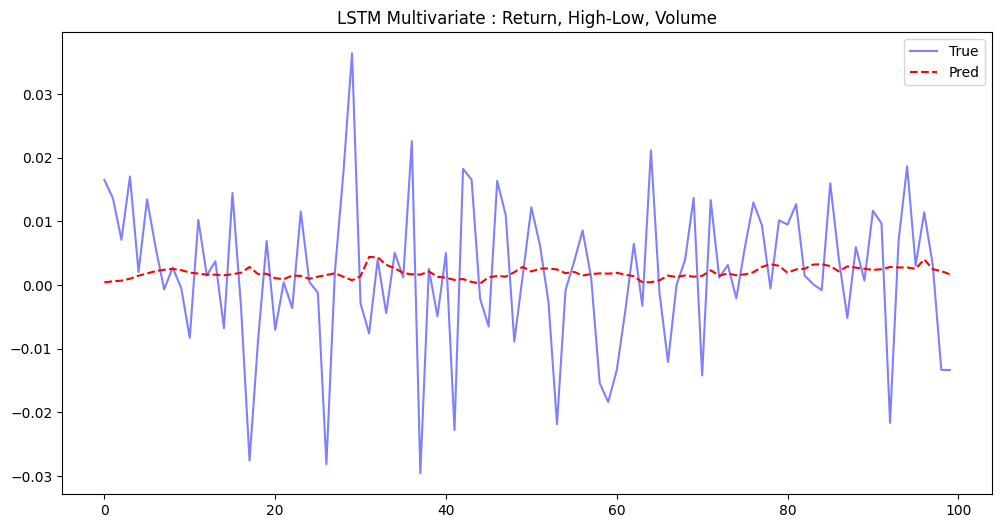

In [17]:
plt.figure(figsize=(12, 6))

plt.plot(y_test_real, label='True', color='blue', alpha=0.5)
plt.plot(predictions, label='Pred', color='red', linestyle='--')
plt.title('LSTM Multivariate : Return, High-Low, Volume')
plt.legend()
plt.show()

# Features

In [43]:
def MACD(df):
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    macd = exp1 - exp2
    return macd

def RSI(df, period=14):
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi  

def Drawdown_current(df):
    roll_max = df['Close'].cummax()
    daily_drawdown = df['Close'] / roll_max - 1.0
    return daily_drawdown

def volatility_rolling(df, window):
    return df['log_return'].rolling(window).std()

In [68]:
tab = [0, 1, 2, 3, 4, 5]
print(tab[1:3])

print(tab[3:4])

[1, 2]
[3]


In [ ]:
def WFCV(X, y, step_size, fold_size, model): 
    step_size = 50
    fold_size = 200

    predictions = []
    truths = []
    mse_tab = []

    for start in range(0, len(X) - fold_size - step_size, step_size):
        train_X = X.iloc[start : start + fold_size]
        train_y = y.iloc[start : start + fold_size]
        test_X = X.iloc[start + fold_size : start + fold_size + step_size]
        test_y = y.iloc[start + fold_size : start + fold_size + step_size]    

        model.fit(train_X, train_y)
        pred = model.predict(test_X)        
        
        predictions.extend(pred)
        truths.extend(test_y)

        mse = mean_squared_error(truths, predictions)
        mse_tab.append(mse)

    return np.array(predictions), np.array(truths), np.array(mse_tab), r2_score(truths, predictions)

In [ ]:
def shuffle_train(y_train):
    perm = np.random.permutation(len(y_train))
    return y_train[perm]

"""

def p_value(df):

"""
    
    

'\n\ndef p_value(df):\n\n'

In [54]:
df

Price,Close,High,Low,Open,Volume,return,log_return,log_volume,high-low,MACD,RSI,Drawdown,Volatility_20,Volatility_60
Date,,,,,,,,,,,,,,
2010-03-31,7.047894,7.096180,7.031699,7.062590,430659600,-0.003604,-0.003611,19.880829,0.064481,0.191926,67.197444,-0.003604,0.011924,0.017348
2010-04-01,7.076987,7.159762,6.980416,7.120175,603145200,0.004128,0.004119,20.217669,0.179346,0.194837,67.042331,0.000000,0.011928,0.017351
2010-04-05,7.152564,7.153164,7.040997,7.047296,684507600,0.010679,0.010623,20.344210,0.112167,0.200926,76.880538,0.000000,0.009235,0.017233
2010-04-06,7.184056,7.205049,7.107878,7.143868,447017200,0.004403,0.004393,19.918108,0.097171,0.205919,77.247920,0.000000,0.009194,0.017228
2010-04-07,7.215845,7.255433,7.157661,7.184354,628502000,0.004425,0.004415,20.258850,0.097771,0.210020,78.993537,0.000000,0.008641,0.017221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-23,254.120667,254.498945,252.308854,253.622918,40858800,0.003065,0.003060,17.525633,2.190092,5.745820,73.865398,0.000000,0.008894,0.011444
2024-12-24,257.037476,257.047410,254.140559,254.339671,23234700,0.011478,0.011413,16.961157,2.906851,6.046646,76.180669,0.000000,0.008829,0.011189
2024-12-26,257.853760,258.928914,256.470034,257.027510,27237100,0.003176,0.003171,17.120091,2.458880,6.278546,76.812106,0.000000,0.008783,0.010408


In [ ]:
start_date = "2010-01-01"
end_date = "2024-12-31"

# Dataset
df = yf.download("AAPL", start=start_date, end=end_date)

# Cette commande garde le niveau 0 ('Close', 'High'...) et jette le niveau 1 ('AAPL')
df.columns = df.columns.droplevel(1)

# Vérification : Affiche les nouvelles colonnes
print(df.columns)

# Features
df["return"] = df["Close"].pct_change()
df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))
df["log_volume"] = np.log(1 + df["Volume"])
df["high-low"] = df["High"] - df["Low"]

df = df.dropna()


/var/folders/vp/6wb8xsys5v93hnh1zt4zdj5w0000gn/T/ipykernel_28251/2813678749.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("AAPL", start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')


In [55]:
df["MACD"] = MACD(df)
df["RSI"] = RSI(df)
df["Drawdown"] = Drawdown_current(df)
df["Volatility_20"] = volatility_rolling(df, window=20)
df["Volatility_60"] = volatility_rolling(df, window=60)

lags = list(range(1, 11))
for lag in lags:
    df[f'lag_{lag}'] = df['log_return'].shift(lag)



In [60]:
df.head(100)
df.dropna(inplace=True)
df

Price,Close,High,Low,Open,Volume,return,log_return,log_volume,high-low,MACD,...,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
Date,,,,,,,,,,,,,,,,,,,,,
2010-06-24,8.067591,8.193553,8.040598,8.127572,714277200,-0.007270,-0.007297,20.386782,0.152955,0.155118,...,-0.010572,0.013529,-0.014332,0.008060,0.017139,0.028697,0.021052,0.003033,0.011905,0.029615
2010-06-25,7.998612,8.105680,7.971920,8.099383,549942400,-0.008550,-0.008587,20.125324,0.133761,0.146245,...,-0.007297,-0.010572,0.013529,-0.014332,0.008060,0.017139,0.028697,0.021052,0.003033,0.011905
2010-06-28,8.046597,8.090084,7.933230,8.005508,584948000,0.005999,0.005981,20.187034,0.156854,0.141456,...,-0.008587,-0.007297,-0.010572,0.013529,-0.014332,0.008060,0.017139,0.028697,0.021052,0.003033
2010-06-29,7.682802,7.929329,7.626719,7.921230,1133344800,-0.045211,-0.046265,20.848439,0.302610,0.107070,...,0.005981,-0.008587,-0.007297,-0.010572,0.013529,-0.014332,0.008060,0.017139,0.028697,0.021052
2010-06-30,7.543648,7.736790,7.498062,7.699001,739452000,-0.018112,-0.018278,20.421420,0.238728,0.067809,...,-0.046265,0.005981,-0.008587,-0.007297,-0.010572,0.013529,-0.014332,0.008060,0.017139,0.028697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-23,254.120667,254.498945,252.308854,253.622918,40858800,0.003065,0.003060,17.525633,2.190092,5.745820,...,0.018641,0.006990,-0.021655,0.009673,0.011659,0.000685,0.005946,-0.005179,0.004125,0.015973
2024-12-24,257.037476,257.047410,254.140559,254.339671,23234700,0.011478,0.011413,16.961157,2.906851,6.046646,...,0.003060,0.018641,0.006990,-0.021655,0.009673,0.011659,0.000685,0.005946,-0.005179,0.004125
2024-12-26,257.853760,258.928914,256.470034,257.027510,27237100,0.003176,0.003171,17.120091,2.458880,6.278546,...,0.011413,0.003060,0.018641,0.006990,-0.021655,0.009673,0.011659,0.000685,0.005946,-0.005179


In [ ]:
features = ['high-low', 'log_volume', 'MACD', 'RSI', 'Drawdown', 'Volatility_20', 'Volatility_60'] + [f'lag_{lag}' for lag in lags]
data = df[features].values  # Shape: (N, 18)

r2_scores = []
r2_score_true = WFCV(data, df['log_return'].values, step_size=50, fold_size=200, model=RandomForestRegressor(n_estimators=100, max_depth=3, random_state=42))[-1]
print(f"R2 score with true labels: {r2_score_true:.6f}")


for _ in range(100):
    y_train_shuffled = shuffle_train(df['log_return'].values)
    r2_score_shuffle = WFCV(data, y_train_shuffled, step_size=50, fold_size=200, model=RandomForestRegressor(n_estimators=100, max_depth=3, random_state=42))[-1]
    print(f"R2 score with shuffled labels: {r2_score_shuffle:.6f}")



R2 score with true labels: 0.018716
R2 score with shuffled labels: -0.100641
R2 score with shuffled labels: -0.104821
R2 score with shuffled labels: -0.167437
R2 score with shuffled labels: -0.093623
R2 score with shuffled labels: -0.096143
R2 score with shuffled labels: -0.106111
R2 score with shuffled labels: -0.097477
R2 score with shuffled labels: -0.147525
R2 score with shuffled labels: -0.098770
R2 score with shuffled labels: -0.146722
R2 score with shuffled labels: -0.075557
R2 score with shuffled labels: -0.174205
R2 score with shuffled labels: -0.122793
R2 score with shuffled labels: -0.106174
R2 score with shuffled labels: -0.168816
R2 score with shuffled labels: -0.069299
R2 score with shuffled labels: -0.103942
R2 score with shuffled labels: -0.099621
R2 score with shuffled labels: -0.182761
R2 score with shuffled labels: -0.124475
R2 score with shuffled labels: -0.131119
R2 score with shuffled labels: -0.283280
R2 score with shuffled labels: -0.136567
R2 score with shuffle

pred oos
truths

reg lin ols (pred oos, truths)

t stat - p value; avantage très rapide et donne une p value assez acceptable et facile a mettre en place pour les autres modèles 

mieux que le r2 : la p value

